In [1]:
import os
import re
from typing import Optional
import pandas as pd
import pm4py
import matplotlib.pyplot as plt

## Summary of Actions


- The Simulator adds the container to the realm of the Optimizer: 2024-11-14 10:26:30 INFO adding TO TO_CO_TFTU000001, EMT 2024-11-14 10:26:28+01:00
- The Simulator lets your own Vehicle Optimizer run every certain amount of time and the logs show the job sequence per Straddle Carrier per Optimization run:
    - 2024-11-14 10:27:07 INFO SC001 schedule 1:TO_CO_TFTU000018#CO_TFTU000018#PICK,2:TO_CO_TFTU000018#CO_TFTU000018#DROP
    - 2024-11-14 10:27:07 INFO SC002 schedule 1:TO_CO_TFTU000023#CO_TFTU000023#PICK,2:TO_CO_TFTU000023#CO_TFTU000023#DROP

- Additional information regarding what a Straddle Carrier does it listed as follows:
    - 2024-11-14 10:27:07 INFO SC001 starting TO_CO_TFTU000018#CO_TFTU000018#PICK: travel 2024-11-14 10:27:00+01:00
    - 2024-11-14 10:27:30+01:00, action 2024-11-14 10:27:30+01:00 - 2024-11-14 10:28:30+01:00 (to pick up the container, the Straddle Carrier has to travel (30 seconds) and pick up the container (60 seconds).
    - 2024-11-14 10:27:10 INFO SC001 (TO: TO_CO_TFTU000018, CO: CO_TFTU000018, PICK) driving to QC003; 31 s; 172693 mm (Straddle Carrier is driving to a location, driving time and distance is shown – distance is measured in Manhattan Distance)
    - 2024-11-14 10:27:10 DEBUG location QC001: using lane 0 for CO CO_TFTU000001 (shows when a Straddle Carrier is using one of the available and limited spaces in a location)
    - 2024-11-14 10:27:10 INFO SC004 (TO: TO_CO_TFTU000001, CO: CO_TFTU000001, PICK) working at QC001; 60 s (the straddle carrier is picking up the container)
    - 2024-11-14 10:28:07 DEBUG location QC001: freeing lane 0 for CO CO_TFTU000001 (Straddle Carrier has freed up the limited space in a location)
    - 2024-11-14 10:28:07 INFO SC004 (TO: TO_CO_TFTU000001, CO: CO_TFTU000001, PICK) finished at QC001 (Straddle Carrier has finished picking up the container)
    - 2024-11-14 10:28:07 DEBUG finished expected schedule_element TO_CO_TFTU000001#CO_TFTU000001#PICK (Straddle Carrier has finished the logical element of the PICK which we call “schedule_element”)

In [2]:
# Path to data files
data_root_path = "../data"
log_file_path = os.path.join(data_root_path, "logger_all.log")
meta_file_path = os.path.join(data_root_path, "VOSimu-InputInformation.xlsx")

In [3]:
vehicles_meta_df = pd.read_excel("../data/VOSimu-InputInformation.xlsx", sheet_name="Vehicles")
locations_meta_df = pd.read_excel("../data/VOSimu-InputInformation.xlsx", sheet_name="Locations")
co_meta_df = pd.read_excel("../data/VOSimu-InputInformation.xlsx", sheet_name="ContainerOrders")

In [4]:
vehicles_meta_df.rename(columns={"ID": "id", "StartLocation": "start_location", "LogOn": "log_on", "LogOff": "log_off"}, inplace=True)
locations_meta_df.rename(columns={"Location Name": "location", "X-Coordinate [mm]": "x", "Y-Coordinate [mm]": "y", "Capacity limitation (# SC)": "capacity"}, inplace=True)
co_meta_df.rename(columns={"TractorOrderId": "to_id", "ContainerOrderId": "co_id", "ContainerName": "container_name", "Length": "length", "OriginLocation": "origin", "DestinationLocation": "dest", "Time first known": "time_first_known"},
                  inplace=True)

In [5]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Trim all object columns to ensure consistency across tables
    """
    object_cols = df.select_dtypes('object').columns
    df[object_cols] = df[object_cols].apply(lambda x: x.str.strip())
    return df


vehicles_meta_df = preprocess_data(vehicles_meta_df)
locations_meta_df = preprocess_data(locations_meta_df)
co_meta_df = preprocess_data(co_meta_df)

In [6]:
with open(log_file_path, "r") as log_fp:
    log_lines = open(log_file_path, "r").readlines()

In [7]:
### Define the regex patterns for common elements in the logs
datetime_pattern = r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}"
log_level_pattern = r"[A-Z]+"
vehicle_id_pattern = r"SC\d{3}"
to_id_pattern = r"TO_CO_TFTU\d{6}"
co_id_pattern = r"CO_TFTU\d{6}"
vehicle_status_pattern = r"(finished|working|waited)"
action_pattern = r"(PICK|DROP)"
tz_aware_datetime_pattern = r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}[+-]\d{2}:\d{2}"
location_pattern = r"((QC)\d{3}|(RAIL)\d{3}.\d{2,3}|(WS|YARD)\d{3}.\d{2})"

### Define regex to extract key information from the logs based on certain patterns
log_patterns = {
    "container_submission": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"
        rf"(?P<log_level>{log_level_pattern})\s+"
        rf"adding TO (?P<to_id>{to_id_pattern}),\s+"
        rf"EMT (?P<submission_time>{tz_aware_datetime_pattern})"
    ),
    "schedule": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"
        rf"(?P<log_level>{log_level_pattern})\s+"
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+"
        rf"schedule\s+(\d:({to_id_pattern})#({co_id_pattern})#({action_pattern}),?)+"
    ),
    "travel_action": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (INFO, ERROR, etc.)
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+starting\s+"  # Vehicle ID
        rf"(?P<to_id>{to_id_pattern})#"  # TO ID
        rf"(?P<co_id>{co_id_pattern})#"  # CO ID
        rf"(?P<action>{action_pattern}):\s+travel\s+"  # Action type
        rf"(?P<travel_start_time>{tz_aware_datetime_pattern})\s*-\s*"  # Travel start time
        rf"(?P<travel_end_time>{tz_aware_datetime_pattern}),\s*action\s+"  # Travel end time
        rf"(?P<action_start_time>{tz_aware_datetime_pattern})\s*-\s*"  # Action start time
        rf"(?P<action_end_time>{tz_aware_datetime_pattern})"  # Action end time
    ),
    "driving": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (INFO, WARN, etc.)
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+"  # Vehicle ID
        rf"\(TO:\s+(?P<to_id>{to_id_pattern}),\s+"  # TO ID
        rf"CO:\s+(?P<co_id>{co_id_pattern}),\s+"  # CO ID
        rf"(?P<action>{action_pattern})\)\s+"  # Action type (e.g., PICK, DROP)
        rf"driving to\s+(?P<location_name>{location_pattern});\s+"  # Location name
        rf"(?P<duration_in_s>\d+)\s+s;\s+"  # Duration in seconds
        rf"(?P<distance_in_mm>\d+)\s+mm"  # Distance in millimeters
    ),
    "lane_usage": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (DEBUG, INFO, etc.)
        rf"location\s+(?P<location_name>{location_pattern}):\s+"  # Location name
        rf"(?P<action>(using|freeing))\s+"
        rf"lane\s+(?P<lane_number>\d+)\s+for CO\s+"  # Lane number
        rf"(?P<co_id>{co_id_pattern})"  # CO ID
    ),
    "position_tracking": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"
        rf"(?P<log_level>{log_level_pattern})\s+"
        rf"(?P<vehicle_id>{vehicle_id_pattern}) now at position\s+"
        rf"\((?P<x>\d+),\s+(?P<y>\d+)\)"
    ),
    "action": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (INFO, DEBUG, etc.)
        rf"(?P<vehicle_id>{vehicle_id_pattern})\s+"  # Vehicle ID
        rf"\(TO:\s+(?P<to_id>{to_id_pattern}),\s+"  # TO ID
        rf"CO:\s+(?P<co_id>{co_id_pattern}),\s+"  # CO ID
        rf"(?P<action>{action_pattern})\)\s+"  # Action type (PICK, DROP)
        rf"(?P<status>{vehicle_status_pattern})\s+at\s+"  # Vehicle status (finished, working, waited)
        rf"(?P<location_name>{location_pattern})"  # Location name
        rf"(;\s+(?P<duration_in_s>\d+)\s+s)?"  # Duration in seconds
    ),
    "finish_schedule_element": re.compile(
        rf"(?P<log_time>{datetime_pattern})\s+"  # Log timestamp
        rf"(?P<log_level>{log_level_pattern})\s+"  # Log level (DEBUG, INFO, etc.)
        rf"finished expected schedule_element\s+"  # Fixed phrase
        rf"(?P<to_id>{to_id_pattern})#"  # TO ID
        rf"(?P<co_id>{co_id_pattern})#"  # CO ID
        rf"(?P<action>{action_pattern})"  # Action (PICK, DROP, etc.)
    )
}


def parse_log(log: str) -> tuple[Optional[str], Optional[dict]]:
    """
    Parse the log string based on regex patterns. If the pattern matches one of the expected patterns, the name of the pattern along with the extracted data from the log will be returned. If the pattern does not match any of those 
    expected, None will be returned
    :param log: A log formatted as string
    :return: (log_pattern, data) if the log matches an expected pattern. Otherwise, (None, None) will be returned.
    """
    log_pattern = None
    extracted_data = None
    for log_pattern_name, regex_compiler in log_patterns.items():
        # Check if the log string matches current regex pattern
        match = regex_compiler.match(log)
        if match:
            # Extract named groups if there's a match
            log_pattern = log_pattern_name
            extracted_data = match.groupdict()
            if log_pattern == "schedule":
                schedules = re.findall(rf"\d:(?P<to_id>{to_id_pattern})#(?P<co_id>{co_id_pattern})#(?P<action>{action_pattern})", log)
                extracted_data = {
                    **extracted_data,
                    "schedules": schedules
                }

            break

    return log_pattern, extracted_data

In [8]:
relevant_logs = {log_pattern: [] for log_pattern in log_patterns}
parsed_logs = []

for log_line in log_lines:
    pattern, data = parse_log(log_line.strip())
    if pattern:
        relevant_logs[pattern].append(data)
        parsed_logs.append((pattern, data))

In [9]:
for pattern, logs in relevant_logs.items():
    print(pattern, len(logs))

container_submission 286
schedule 8225
travel_action 572
driving 572
lane_usage 968
position_tracking 572
action 1229
finish_schedule_element 572


# Statistical Analyses

In [10]:
position_tracking_df = pd.DataFrame(relevant_logs["position_tracking"])
position_tracking_df[["x", "y"]] = position_tracking_df[["x", "y"]].astype(int)
position_tracking_df = position_tracking_df.merge(locations_meta_df, how="left", on=["x", "y"])
position_tracking_df

,log_time,log_level,vehicle_id,x,y,location,capacity
0,2024-11-14 10:28:07,DEBUG,SC004,242320,993371,QC001,2.0
1,2024-11-14 10:28:07,DEBUG,SC014,342320,993371,QC003,2.0
2,2024-11-14 10:28:09,DEBUG,SC013,342320,993371,QC003,2.0
3,2024-11-14 10:28:34,DEBUG,SC019,541820,993371,QC005,2.0
4,2024-11-14 10:28:38,DEBUG,SC017,541820,993371,QC005,2.0
...,...,...,...,...,...,...,...
567,2024-11-14 11:37:23,DEBUG,SC015,479241,419607,WS013.01,2.0
568,2024-11-14 11:37:48,DEBUG,SC019,642264,993371,QC006,2.0
569,2024-11-14 11:39:02,DEBUG,SC007,479241,419607,WS013.01,2.0
570,2024-11-14 11:39:40,DEBUG,SC016,479241,469607,WS012.01,2.0


In [11]:
travel_action_df = pd.DataFrame(relevant_logs["travel_action"])
datetime_columns = ["travel_start_time", "travel_end_time", "action_start_time", "action_end_time"]
travel_action_df[datetime_columns] = travel_action_df[datetime_columns].apply(pd.to_datetime)
travel_action_df["expected_travel_duration"] = (travel_action_df["travel_end_time"] - travel_action_df["travel_start_time"]).dt.total_seconds()
travel_action_df["expected_action_duration"] = (travel_action_df["action_end_time"] - travel_action_df["action_start_time"]).dt.total_seconds()
travel_action_df

,log_time,log_level,vehicle_id,to_id,co_id,action,travel_start_time,travel_end_time,action_start_time,action_end_time,expected_travel_duration,expected_action_duration
0,2024-11-14 10:27:07,INFO,SC001,TO_CO_TFTU000018,CO_TFTU000018,PICK,2024-11-14 10:27:00+01:00,2024-11-14 10:27:30+01:00,2024-11-14 10:27:30+01:00,2024-11-14 10:28:30+01:00,30.0,60.0
1,2024-11-14 10:27:07,INFO,SC002,TO_CO_TFTU000023,CO_TFTU000023,PICK,2024-11-14 10:27:00+01:00,2024-11-14 10:27:29+01:00,2024-11-14 10:27:29+01:00,2024-11-14 10:28:29+01:00,29.0,60.0
2,2024-11-14 10:27:07,INFO,SC003,TO_CO_TFTU000020,CO_TFTU000020,PICK,2024-11-14 10:27:00+01:00,2024-11-14 10:27:27+01:00,2024-11-14 10:27:27+01:00,2024-11-14 10:28:27+01:00,27.0,60.0
3,2024-11-14 10:27:07,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,2024-11-14 10:27:00+01:00,2024-11-14 10:27:07+01:00,2024-11-14 10:27:07+01:00,2024-11-14 10:28:07+01:00,7.0,60.0
4,2024-11-14 10:27:07,INFO,SC005,TO_CO_TFTU000019,CO_TFTU000019,PICK,2024-11-14 10:27:00+01:00,2024-11-14 10:27:23+01:00,2024-11-14 10:27:23+01:00,2024-11-14 10:28:23+01:00,23.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:34:10,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,2024-11-14 11:38:59+01:00,2024-11-14 11:41:11+01:00,2024-11-14 11:41:11+01:00,2024-11-14 11:42:11+01:00,132.0,60.0
568,2024-11-14 11:35:29,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,2024-11-14 11:40:19+01:00,2024-11-14 11:41:37+01:00,2024-11-14 11:41:37+01:00,2024-11-14 11:42:37+01:00,78.0,60.0
569,2024-11-14 11:35:49,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,2024-11-14 11:40:39+01:00,2024-11-14 11:42:51+01:00,2024-11-14 11:42:51+01:00,2024-11-14 11:43:51+01:00,132.0,60.0
570,2024-11-14 11:36:54,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,2024-11-14 11:41:49+01:00,2024-11-14 11:43:34+01:00,2024-11-14 11:43:34+01:00,2024-11-14 11:44:34+01:00,105.0,60.0


In [12]:
driving_df = pd.DataFrame(relevant_logs["driving"]).rename(columns={"duration_in_s": "driving_time"})
driving_df[["driving_time", "distance_in_mm"]] = driving_df[["driving_time", "distance_in_mm"]].astype(int)
driving_df

,log_time,log_level,vehicle_id,to_id,co_id,action,location_name,driving_time,distance_in_mm
0,2024-11-14 10:27:10,INFO,SC001,TO_CO_TFTU000018,CO_TFTU000018,PICK,QC003,31,172693
1,2024-11-14 10:27:10,INFO,SC002,TO_CO_TFTU000023,CO_TFTU000023,PICK,QC003,29,162693
2,2024-11-14 10:27:10,INFO,SC003,TO_CO_TFTU000020,CO_TFTU000020,PICK,QC003,27,152693
3,2024-11-14 10:27:10,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,QC001,8,42693
4,2024-11-14 10:27:10,INFO,SC005,TO_CO_TFTU000019,CO_TFTU000019,PICK,QC003,24,132693
...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:34:10,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,WS013.01,133,736787
568,2024-11-14 11:35:29,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,QC006,79,436787
569,2024-11-14 11:35:49,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,WS013.01,133,736787
570,2024-11-14 11:36:54,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,WS012.01,106,586343


In [13]:
action_df = pd.DataFrame(relevant_logs["action"])
action_df['duration_in_s'] = action_df['duration_in_s'].fillna(0.0).astype(int)
waiting_df = action_df[action_df['status'] == "waited"].rename(columns={"duration_in_s": "waiting_time"})
working_df = action_df[action_df['status'] == "working"].rename(columns={"duration_in_s": "processing_time"})

merged_df = working_df.merge(waiting_df[["co_id", "action", "waiting_time"]], how="left", on=["co_id", "action"]).drop(columns=["status"])
merged_df["waiting_time"] = merged_df["waiting_time"].fillna(0.0)
merged_df

,log_time,log_level,vehicle_id,to_id,co_id,action,location_name,processing_time,waiting_time
0,2024-11-14 10:27:10,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,QC001,60,0.0
1,2024-11-14 10:27:10,INFO,SC014,TO_CO_TFTU000005,CO_TFTU000005,PICK,QC003,60,0.0
2,2024-11-14 10:27:10,INFO,SC013,TO_CO_TFTU000007,CO_TFTU000007,PICK,QC003,60,0.0
3,2024-11-14 10:27:34,INFO,SC019,TO_CO_TFTU000002,CO_TFTU000002,PICK,QC005,60,0.0
4,2024-11-14 10:27:38,INFO,SC017,TO_CO_TFTU000016,CO_TFTU000016,PICK,QC005,60,0.0
...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:36:23,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,WS013.01,60,0.0
568,2024-11-14 11:36:48,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,QC006,60,0.0
569,2024-11-14 11:38:02,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,WS013.01,60,0.0
570,2024-11-14 11:38:40,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,WS012.01,60,0.0


In [14]:
merged_df = (merged_df
             .merge(driving_df[["to_id", "co_id", "action", "driving_time", "distance_in_mm"]], on=['to_id', 'co_id', 'action'], how='left')
             .merge(travel_action_df[["to_id", "co_id", "action", "expected_travel_duration", "expected_action_duration"]], on=['to_id', 'co_id', 'action'], how='left')
             )
merged_df["total_time_reported"] = merged_df["driving_time"] + merged_df["waiting_time"] + merged_df["processing_time"]
merged_df["total_time_expected"] = merged_df["expected_travel_duration"] + merged_df["expected_action_duration"]
merged_df

,log_time,log_level,vehicle_id,to_id,co_id,action,location_name,processing_time,waiting_time,driving_time,distance_in_mm,expected_travel_duration,expected_action_duration,total_time_reported,total_time_expected
0,2024-11-14 10:27:10,INFO,SC004,TO_CO_TFTU000001,CO_TFTU000001,PICK,QC001,60,0.0,8,42693,7.0,60.0,68.0,67.0
1,2024-11-14 10:27:10,INFO,SC014,TO_CO_TFTU000005,CO_TFTU000005,PICK,QC003,60,0.0,8,42693,7.0,60.0,68.0,67.0
2,2024-11-14 10:27:10,INFO,SC013,TO_CO_TFTU000007,CO_TFTU000007,PICK,QC003,60,0.0,9,52693,9.0,60.0,69.0,69.0
3,2024-11-14 10:27:34,INFO,SC019,TO_CO_TFTU000002,CO_TFTU000002,PICK,QC005,60,0.0,35,192193,34.0,60.0,95.0,94.0
4,2024-11-14 10:27:38,INFO,SC017,TO_CO_TFTU000016,CO_TFTU000016,PICK,QC005,60,0.0,38,212193,38.0,60.0,98.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,2024-11-14 11:36:23,INFO,SC015,TO_CO_TFTU000274,CO_TFTU000274,DROP,WS013.01,60,0.0,133,736787,132.0,60.0,193.0,192.0
568,2024-11-14 11:36:48,INFO,SC019,TO_CO_TFTU000281,CO_TFTU000281,PICK,QC006,60,0.0,79,436787,78.0,60.0,139.0,138.0
569,2024-11-14 11:38:02,INFO,SC007,TO_CO_TFTU000269,CO_TFTU000269,DROP,WS013.01,60,0.0,133,736787,132.0,60.0,193.0,192.0
570,2024-11-14 11:38:40,INFO,SC016,TO_CO_TFTU000285,CO_TFTU000285,DROP,WS012.01,60,0.0,106,586343,105.0,60.0,166.0,165.0


In [21]:
total_duration_estimate_error = (merged_df["total_time_reported"] - merged_df["total_time_expected"]).sum()
avg_waiting_time = merged_df.groupby(["action"])["waiting_time"].mean()
total_distance_traveled = merged_df.groupby("vehicle_id")["distance_in_mm"].sum()

vehicle_id
SC001    11330100
SC002    12854478
SC003    12012474
SC004    11600552
SC005     9654062
SC006    12569244
SC007    13054210
SC008    13612804
SC009    12970860
SC010    12538644
SC011    12160818
SC012    12065750
SC013    13135784
SC014    10983602
SC015    12482336
SC016    14156884
SC017    13716534
SC018    11700850
SC019    13133566
SC020    11056102
Name: distance_in_mm, dtype: int64

In [22]:
vehicle_location_df = vehicles_meta_df.merge(locations_meta_df, how="left", left_on="start_location", right_on="location")
vehicle_location_df

,id,start_location,log_on,log_off,location,x,y,capacity
0,SC001,YARD001.09,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.09,212302,950696,NaN
1,SC002,YARD001.10,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.10,222302,950696,NaN
2,SC003,YARD001.11,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.11,232302,950696,NaN
3,SC004,YARD001.12,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.12,242302,950696,NaN
4,SC005,YARD001.13,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.13,252302,950696,NaN
5,SC006,YARD001.14,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.14,262302,950696,NaN
6,SC007,YARD001.15,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.15,272302,950696,NaN
7,SC008,YARD001.16,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.16,282302,950696,NaN
8,SC009,YARD001.17,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.17,292302,950696,NaN
9,SC010,YARD001.18,2024-08-21 06:40:00,2024-08-21 16:30:00,YARD001.18,302302,950696,NaN


In [23]:
co_location_df = (co_meta_df
                  .merge(locations_meta_df, how="left", left_on="origin", right_on="location")
                  .drop(columns=["location", "capacity"])
                  .rename(columns={"x": "origin_x", "y": "origin_y"})
                  .merge(locations_meta_df, how="left", left_on="dest", right_on="location")
                  .drop(columns=["location", "capacity"])
                  .rename(columns={"x": "dest_x", "y": "dest_y"})
                  )
co_location_df

,to_id,co_id,container_name,length,origin,dest,time_first_known,origin_x,origin_y,dest_x,dest_y
0,TO_CO_TFTU000067,CO_TFTU000067,TFTU000067,20,QC005,WS001.01,2024-08-21 07:12:00,541820,993371,479241,919607
1,TO_CO_TFTU000121,CO_TFTU000121,TFTU000121,40,QC003,WS001.01,2024-08-21 07:21:00,342320,993371,479241,919607
2,TO_CO_TFTU000156,CO_TFTU000156,TFTU000156,40,QC006,WS001.01,2024-08-21 07:28:00,642264,993371,479241,919607
3,TO_CO_TFTU000175,CO_TFTU000175,TFTU000175,40,QC003,WS001.01,2024-08-21 07:35:00,342320,993371,479241,919607
4,TO_CO_TFTU000211,CO_TFTU000211,TFTU000211,40,QC005,WS001.01,2024-08-21 07:45:00,541820,993371,479241,919607
...,...,...,...,...,...,...,...,...,...,...,...
281,TO_CO_TFTU000151,CO_TFTU000151,TFTU000151,20,QC006,YARD001.57,2024-08-21 07:27:00,642264,993371,692302,950696
282,TO_CO_TFTU000166,CO_TFTU000166,TFTU000166,20,QC003,YARD001.57,2024-08-21 07:31:00,342320,993371,692302,950696
283,TO_CO_TFTU000059,CO_TFTU000059,TFTU000059,20,QC006,YARD001.58,2024-08-21 07:11:00,642264,993371,702302,950696
284,TO_CO_TFTU000005,CO_TFTU000005,TFTU000005,20,QC003,YARD001.59,2024-08-21 07:01:00,342320,993371,712302,950696


In [27]:
vehicle_travel_df = position_tracking_df.groupby("vehicle_id", as_index=False).agg({"x": lambda x: list(x), "y": lambda y: list(y)})
x, y = vehicle_travel_df.iloc[10]["x"], vehicle_travel_df.iloc[10]["y"]

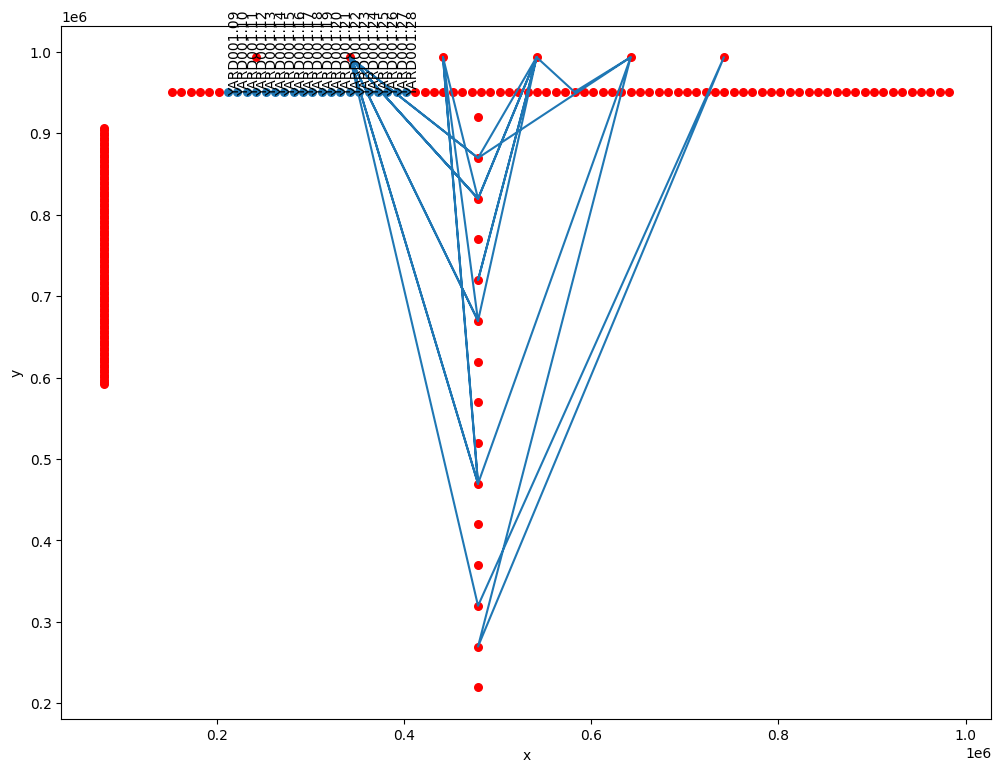

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
vehicle_location_df.plot("x", "y", kind="scatter", s=30, ax=ax)

for i, row in vehicle_location_df.iterrows():
    ax.annotate(row['location'], (row['x'], row['y']), fontsize=10, rotation=90)

remaining_locs_df = locations_meta_df[~locations_meta_df["location"].isin(vehicles_meta_df["start_location"].values)]
remaining_locs_df.plot("x", "y", kind="scatter", ax=ax, c="r", s=30)
plt.plot(x, y)

In [29]:
all_data = []
all_data.extend([parsed_log[1] for parsed_log in parsed_logs])
all_data = pd.DataFrame(all_data)
all_data[(all_data.to_id == "TO_CO_TFTU000001") | (all_data.co_id == "CO_TFTU000001")]

,log_time,log_level,to_id,submission_time,vehicle_id,schedules,co_id,action,travel_start_time,travel_end_time,action_start_time,action_end_time,location_name,duration_in_s,distance_in_mm,lane_number,status,x,y
0,2024-11-14 10:26:30,INFO,TO_CO_TFTU000001,2024-11-14 10:26:28+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,2024-11-14 10:27:07,INFO,TO_CO_TFTU000001,NaN,SC004,NaN,CO_TFTU000001,PICK,2024-11-14 10:27:00+01:00,2024-11-14 10:27:07+01:00,2024-11-14 10:27:07+01:00,2024-11-14 10:28:07+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2024-11-14 10:27:10,INFO,TO_CO_TFTU000001,NaN,SC004,NaN,CO_TFTU000001,PICK,NaN,NaN,NaN,NaN,QC001,8,42693,NaN,NaN,NaN,NaN
115,2024-11-14 10:27:10,DEBUG,NaN,NaN,NaN,NaN,CO_TFTU000001,using,NaN,NaN,NaN,NaN,QC001,NaN,NaN,0,NaN,NaN,NaN
117,2024-11-14 10:27:10,INFO,TO_CO_TFTU000001,NaN,SC004,NaN,CO_TFTU000001,PICK,NaN,NaN,NaN,NaN,QC001,60,NaN,NaN,working,NaN,NaN
255,2024-11-14 10:28:07,DEBUG,NaN,NaN,NaN,NaN,CO_TFTU000001,freeing,NaN,NaN,NaN,NaN,QC001,NaN,NaN,0,NaN,NaN,NaN
256,2024-11-14 10:28:07,INFO,TO_CO_TFTU000001,NaN,SC004,NaN,CO_TFTU000001,PICK,NaN,NaN,NaN,NaN,QC001,None,NaN,NaN,finished,NaN,NaN
258,2024-11-14 10:28:07,DEBUG,TO_CO_TFTU000001,NaN,NaN,NaN,CO_TFTU000001,PICK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
259,2024-11-14 10:28:07,INFO,TO_CO_TFTU000001,NaN,SC004,NaN,CO_TFTU000001,DROP,2024-11-14 10:33:02+01:00,2024-11-14 10:34:33+01:00,2024-11-14 10:34:33+01:00,2024-11-14 10:35:33+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,2024-11-14 10:28:07,INFO,TO_CO_TFTU000001,NaN,SC004,NaN,CO_TFTU000001,DROP,NaN,NaN,NaN,NaN,WS007.01,92,510685,NaN,NaN,NaN,NaN


In [30]:
event_log = []
for pattern, log_data in parsed_logs:
    if pattern == "container_submission":
        co_id = log_data["to_id"].removeprefix("TO_")
        submission_start = {
            "to_id": log_data["to_id"],
            "co_id": co_id,
            "action": "submission",
            "timestamp": log_data["submission_time"],
            "lifecycle": "start"
        }
        submission_end = {
            "to_id": log_data["to_id"],
            "co_id": co_id,
            "action": "submission",
            "timestamp": log_data["submission_time"],
            "lifecycle": "complete"
        }
        event_log.extend([submission_start, submission_end])
    elif pattern == "schedule":
        for schedule_data in log_data["schedules"]:
            to_id, co_id, action = schedule_data[:3]
            event_log.append({
                "to_id": to_id,
                "co_id": co_id,
                "vehicle_id": None,
                "action": "pick container" if action == "PICK" else "drop container",
                "timestamp": log_data["log_time"],
                "lifecycle": "schedule"
            })
    elif pattern == "travel_action":
        travel_start = {
            "to_id": log_data["to_id"],
            "co_id": log_data["co_id"],
            "vehicle_id": log_data["vehicle_id"],
            "action": "deploy vehicle to pick container" if log_data["action"] == "PICK" else "deploy vehicle to drop container",
            "timestamp": log_data["travel_start_time"],
            "lifecycle": "start"
        }
        travel_end = {
            "to_id": log_data["to_id"],
            "co_id": log_data["co_id"],
            "vehicle_id": log_data["vehicle_id"],
            "action": "deploy vehicle to pick container" if log_data["action"] == "PICK" else "deploy vehicle to drop container",
            "timestamp": log_data["travel_start_time"],
            "lifecycle": "complete"
        }
        action_start = {
            "to_id": log_data["to_id"],
            "co_id": log_data["co_id"],
            "vehicle_id": log_data["vehicle_id"],
            "action": "pick container" if log_data["action"] == "PICK" else "drop container",
            "timestamp": log_data["action_start_time"],
            "lifecycle": "start"
        }
        action_end = {
            "to_id": log_data["to_id"],
            "co_id": log_data["co_id"],
            "vehicle_id": log_data["vehicle_id"],
            "action": "pick container" if log_data["action"] == "PICK" else "drop container",
            "timestamp": log_data["action_end_time"],
            "lifecycle": "complete"
        }
        event_log.extend([travel_start, travel_end, action_start, action_end])
    elif pattern == "action":
        if log_data["status"] == "waited":
            action_end = {
                "to_id": log_data["to_id"],
                "co_id": log_data["co_id"],
                "vehicle_id": log_data["vehicle_id"],
                "action": "wait for a lane to be freed",
                "timestamp": log_data["action_end_time"],
                "lifecycle": "complete"
            }



In [31]:
event_log_df = pd.DataFrame(event_log)
event_log_df.groupby("co_id", as_index=False).apply(lambda x: x.sort_values('timestamp'))

/tmp/ipykernel_4927/2304532674.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  event_log_df.groupby("co_id", as_index=False).apply(lambda x: x.sort_values('timestamp'))


to_id          co_id                            action  \
0   0      TO_CO_TFTU000001  CO_TFTU000001                        submission   
    1      TO_CO_TFTU000001  CO_TFTU000001                        submission   
    162    TO_CO_TFTU000001  CO_TFTU000001  deploy vehicle to pick container   
    163    TO_CO_TFTU000001  CO_TFTU000001  deploy vehicle to pick container   
    116    TO_CO_TFTU000001  CO_TFTU000001                    pick container   
...                     ...            ...                               ...   
285 27304  TO_CO_TFTU000286  CO_TFTU000286                    pick container   
    26469  TO_CO_TFTU000286  CO_TFTU000286                        submission   
    26468  TO_CO_TFTU000286  CO_TFTU000286                        submission   
    28399  TO_CO_TFTU000286  CO_TFTU000286                    drop container   
    28400  TO_CO_TFTU000286  CO_TFTU000286                    drop container   

                           timestamp lifecycle vehicle_id  
0   0      2024-11-14 10:26:28+01:00     start        NaN  
    1      2024-11-14 10:26:28+01:00  complete        NaN  
    162    2024-11-14 10:27:00+01:00     start      SC004  
    163    2024-11-14 10:27:00+01:00  complete      SC004  
    116          2024-11-14 10:27:07  schedule       None  
...                              ...       ...        ...  
285 27304  2024-11-14 11:33:48+01:00  complete      SC019  
    26469  2024-11-14 11:34:28+01:00  complete        NaN  
    26468  2024-11-14 11:34:28+01:00     start        NaN  
    28399  2024-11-14 11:35:34+01:00     start      SC019  
    28400  2024-11-14 11:36:34+01:00  complete      SC019  

[29995 rows x 6 columns]

In [15]:
event_log = event_log_df.rename(columns={"co_id": "case_id", "action": "activity"})
event_log = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

In [17]:
num_events = len(event_log)
num_cases = len(event_log.case_id.unique())
num_events, num_cases

(29995, 286)

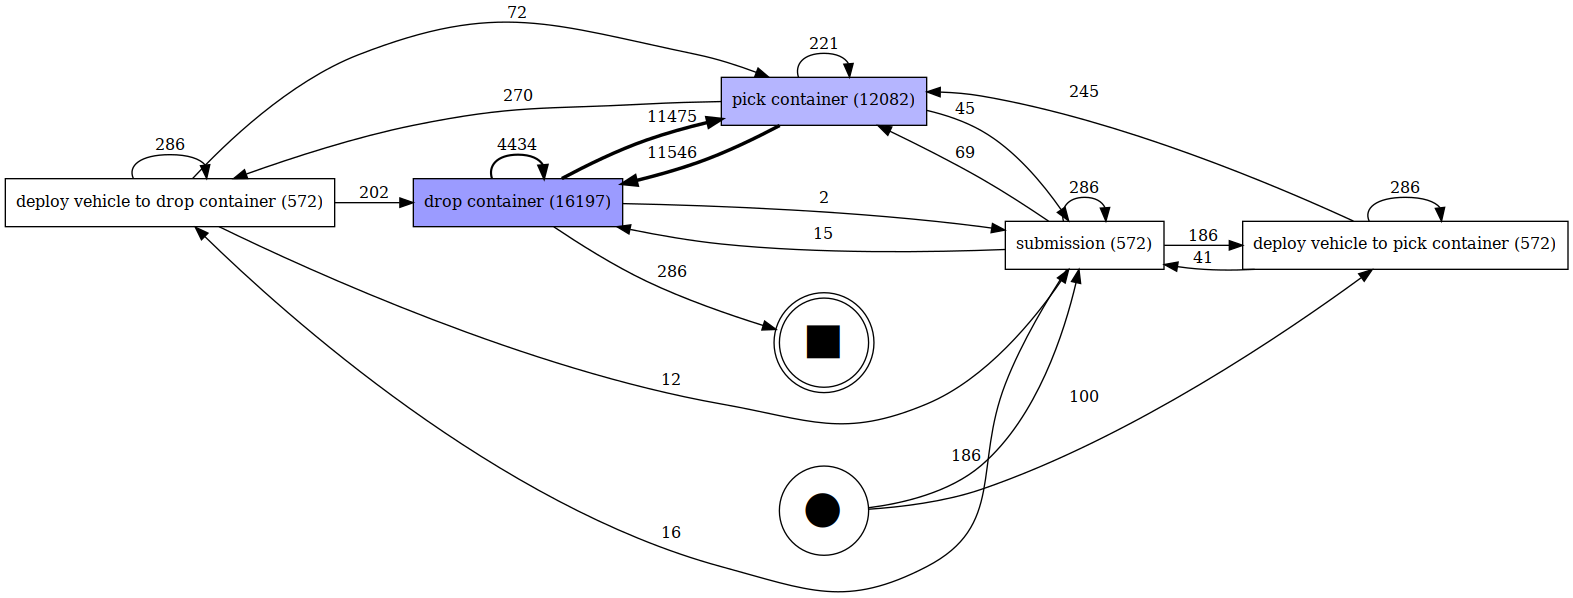

In [19]:
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

Pipeline Overview:

A vehicle is assigned to a specific container. The vehicle drive from its original location to pick up the container. Once picked up, the container is taken all way to its destination and dropped by the vehicle.

Sometimes, some vehicles have to wait on their way to pick up or drop a container due to the occupation of the lanes by other vehicles